In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog

# Replace these paths with your actual folder paths
TRAIN_DIR = "Dog vs Cat/train"
TEST_DIR = "Dog vs Cat/test1"

IMG_SIZE = 128  

In [2]:
def extract_hog_features(img):
    features, _ = hog(img, 
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

In [3]:
def load_training_data():
    data = []
    labels = []
    cat_count = 0
    dog_count = 0

    with tqdm(total=4000, desc="Loading training images") as pbar:
        for img_name in os.listdir(TRAIN_DIR):
            if "cat" in img_name and cat_count < 2000:
                label = 0
                cat_count += 1
            elif "dog" in img_name and dog_count < 2000:
                label = 1
                dog_count += 1
            else:
                continue

            img_path = os.path.join(TRAIN_DIR, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # HOG feature extraction
            features = extract_hog_features(img)
            data.append(features)
            labels.append(label)
            pbar.update(1)

            if cat_count == 2000 and dog_count == 2000:
                break

    return np.array(data), np.array(labels)


In [4]:
def load_test_data():
    test_images = []
    image_ids = []
    for img_name in tqdm(os.listdir(TEST_DIR)[:1000], desc="Loading test images"):
        img_path = os.path.join(TEST_DIR, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        features = extract_hog_features(img)
        test_images.append(features)
        image_ids.append(int(img_name.split(".")[0]))
    return np.array(test_images), image_ids


In [5]:
print("Loading training data...")
X, y = load_training_data()

Loading training data...


Loading training images: 100%|█████████████████████████████████████████████████████| 4000/4000 [02:17<00:00, 29.13it/s]


In [6]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Splitted!")

Data Splitted!


In [7]:
print("Training SVM on HOG features...")
model = SVC(kernel='rbf', C=10, gamma=0.001)
model.fit(X_train, y_train)
print("SVM model trained!")


Training SVM on HOG features...
SVM model trained!


In [8]:
print("Evaluating...")
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.2f}")

📊 Evaluating...
✅ Validation Accuracy: 0.73


In [9]:
print("Loading test data...")
X_test, test_ids = load_test_data()


🔄 Loading test data...


Loading test images: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.87it/s]


In [10]:
print("Predicting on test data...")
test_preds = model.predict(X_test)

Predicting on test data...


In [11]:
# Save predictions to CSV
submission = pd.DataFrame({
    "id": test_ids,
    "label": test_preds
})
submission.to_csv("svm_submission.csv", index=False)
print("Submission file saved as 'svm_submission.csv'")

Submission file saved as 'svm_submission.csv'


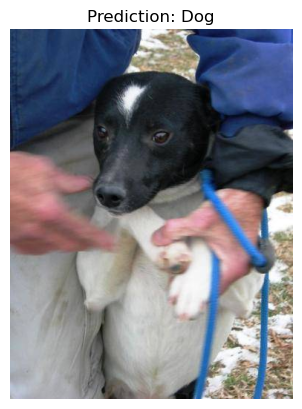

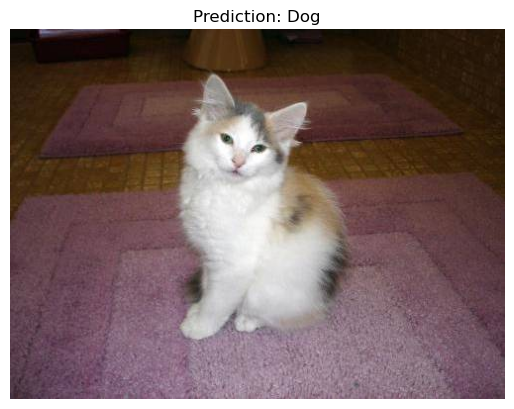

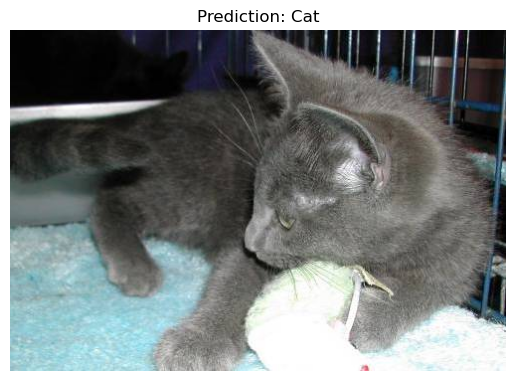

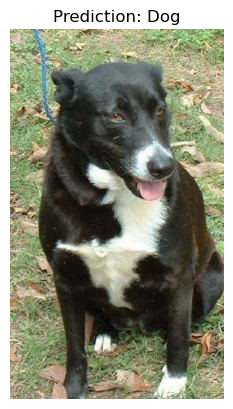

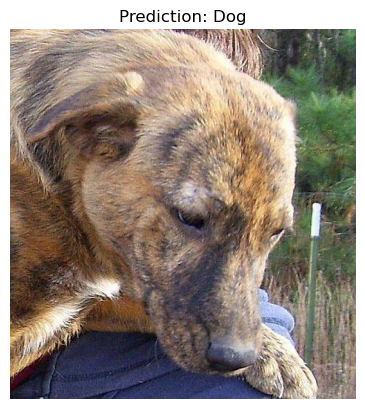

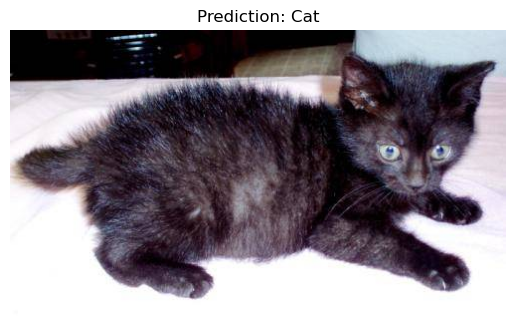

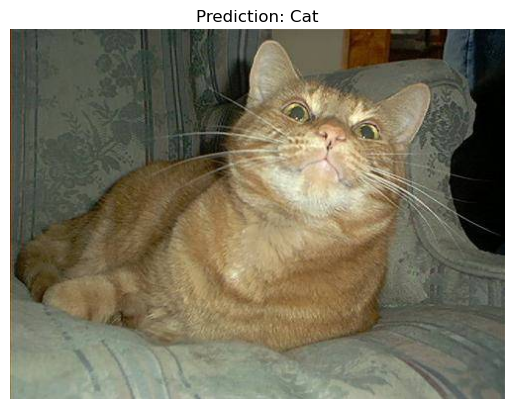

In [13]:
import matplotlib.pyplot as plt

def show_predictions(num=10):
    for i in range(num):
        img_id = test_ids[i]
        pred = test_preds[i]
        img_path = os.path.join(TEST_DIR, f"{img_id}.jpg")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(f"Prediction: {'Dog' if pred == 1 else 'Cat'}")
        plt.axis('off')
        plt.show()

show_predictions(7)
